In [1]:
import numpy as np
import pandas as pd
import geopandas as gpd
from sklearn.impute import SimpleImputer
from sklearn.preprocessing import RobustScaler
from sklearn.cluster import KMeans

In [6]:
res = gpd.read_file(r'../Data/processed/manhattan_residential.geojson')

In [3]:
manhattan = gpd.read_file(r'../Data/processed/manhattan_buildings.geojson')

In [4]:
# res = manhattan[(manhattan['CURTAXCLASS'].isin([1, 2]))].copy()

In [7]:
res.columns

Index(['base_bbl', 'construction_year', 'height_roof', 'bin', 'CURTAXCLASS',
       'CURMKTTOT', 'PYMKTTOT', 'GROSS_SQFT', 'RESIDENTIAL_AREA_GROSS',
       'BLD_STORY', 'ZONING', 'BLDG_CLASS', 'price_per_sqft',
       'price_per_sqft_2024', 'time_taken', 'elevator', 'unitsres',
       'res_share', 'elevator_flag', 'price_inc', 'geometry'],
      dtype='object')

In [10]:
# clustering 1
K = 5
RANDOM_STATE = 42

In [11]:
def kmeans_and_profile_fast(df, k=6, random_state=42, weights=None, stats=("min","median","mean","max")):
    feat_cols = [
        "BLD_STORY",
        "CURMKTTOT",
        "price_per_sqft",
        "price_inc",
    ]
    
    weights = np.array([
        1, # "BLD_STORY"
        3, # "CURMKTTOT"
        3, # "price_per_sqft"
        3, # "price_inc"
    ], dtype=np.float32)

    df[feat_cols] = (
        df[feat_cols]
        .apply(pd.to_numeric, errors="coerce")
        .replace([np.inf, -np.inf], np.nan)
        .astype(np.float32)
    )
    X = df[feat_cols].to_numpy(dtype=np.float32)

    imp = SimpleImputer(strategy="median")
    X_imp = imp.fit_transform(X).astype(np.float32)

    q01 = np.nanpercentile(X_imp, 1, axis=0)
    q99 = np.nanpercentile(X_imp, 99, axis=0)
    X_clip = np.clip(X_imp, q01, q99).astype(np.float32)

    scaler = RobustScaler()
    X_scaled = scaler.fit_transform(X_clip).astype(np.float32)

    X_w = (X_scaled * weights).astype(np.float32)

    km = KMeans(n_clusters=k, n_init=10, algorithm="elkan", random_state=random_state)
    labels = km.fit_predict(X_w)

    # --- Stable relabeling by mean height_roof ---
    label_order = (
        pd.DataFrame({"label": labels, "BLD_STORY": df["BLD_STORY"]})
        .groupby("label")["BLD_STORY"]
        .mean()
        .sort_values()
        .index
        .tolist()
    )
    remap = {old: new for new, old in enumerate(label_order)}
    labels = np.array([remap[l] for l in labels], dtype=np.int32)

    df = df.assign(kmeans_label=labels)

    all_df = km.transform(X_w).astype(np.float32)
    chosen_df = all_df[np.arange(all_df.shape[0]), km.labels_]
    r90 = {c: np.nanpercentile(chosen_df[labels == c], 90) for c in range(k)}
    r95 = {c: np.nanpercentile(chosen_df[labels == c], 95) for c in range(k)}
    conf = 1.0 - np.minimum(
        chosen_df / np.array([r90[c] for c in labels], dtype=np.float32),
        1.0
    )
    df = df.assign(cluster_confidence=conf.astype(np.float32))

    X_clip_df = pd.DataFrame(X_clip, columns=feat_cols, index=df.index)
    X_clip_df["kmeans_label"] = labels
    agg = {c: list(stats) for c in feat_cols}
    prof = X_clip_df.groupby("kmeans_label").agg(agg)
    prof[("n","count")] = X_clip_df.groupby("kmeans_label").size()
    cols = [("n","count")] + [c for c in prof.columns if c != ("n","count")]
    prof = prof.reindex(columns=cols)

    return {
        "data": df,
        "model": km,
        "scaler": scaler,
        "imputer": imp,
        "feature_weights": dict(zip(feat_cols, weights.tolist())),
        "cluster_profile": prof,
        "r90": r90,
        "r95": r95,
    }


In [12]:
results = kmeans_and_profile_fast(res, k=K, random_state=RANDOM_STATE)
manhattan_k = results["data"]
profile = results["cluster_profile"]

In [13]:
print(profile["BLD_STORY"])

              min  median       mean   max
kmeans_label                              
0             2.0     4.0   3.669878   7.0
1             2.0     4.0   3.824205  12.0
2             2.0     5.0   5.577341  23.0
3             2.0    16.0  18.072384  38.0
4             2.0    20.0  21.744560  38.0


In [14]:
print(profile["CURMKTTOT"])

                    min      median         mean        max
kmeans_label                                               
0               80250.0   811562.50   867404.625  3360500.0
1              116000.0  1291875.00  1555919.000  6201988.5
2               45875.0   297375.00   356782.625  1627125.0
3               45875.0  1449781.25  1537840.000  3268062.5
4             3019650.0  4737687.50  4831712.000  6201988.5


In [15]:
print(profile['price_per_sqft'])

                      min       median         mean          max
kmeans_label                                                    
0              910.033752  1667.840210  1665.273682  2366.451660
1             1863.754761  2673.670898  2713.532959  3217.528809
2               33.828571   230.350189   273.932861  1076.250000
3               33.828571   230.428497   224.557404   984.770569
4               51.598652   263.769104   270.361572  2061.703613


In [16]:
print(profile["price_inc"])

                   min    median      mean       max
kmeans_label                                        
0            -0.235471 -0.037630 -0.005523  0.635496
1            -0.235471 -0.000486  0.026364  0.635496
2            -0.235471  0.038289  0.039449  0.635496
3            -0.235471  0.050294  0.080629  0.635496
4            -0.235471  0.038278  0.045476  0.635496


In [17]:
cluster_names = {
    0: 'Compact Expensive Declining Low-Rises',
    1: 'Luxury Mid-Rises',
    2: 'Affordable Walk-Ups',
    3: 'Price Appreciating High-Rises',
    4: 'Large Family Towers'
}

# Apply mapping to your dataframe
results["data"]["cluster_name"] = results["data"]["kmeans_label"].map(cluster_names)

# Also add to profile for easier readability
profile_named = results["cluster_profile"].copy()
profile_named.index = profile_named.index.map(cluster_names)

In [18]:
res_socio = results['data']
res_socio.columns

Index(['base_bbl', 'construction_year', 'height_roof', 'bin', 'CURTAXCLASS',
       'CURMKTTOT', 'PYMKTTOT', 'GROSS_SQFT', 'RESIDENTIAL_AREA_GROSS',
       'BLD_STORY', 'ZONING', 'BLDG_CLASS', 'price_per_sqft',
       'price_per_sqft_2024', 'time_taken', 'elevator', 'unitsres',
       'res_share', 'elevator_flag', 'price_inc', 'geometry', 'kmeans_label',
       'cluster_confidence', 'cluster_name'],
      dtype='object')

In [19]:
res_socio['cluster_name'].value_counts()

cluster_name
Affordable Walk-Ups                      136975
Price Appreciating High-Rises             30780
Compact Expensive Declining Low-Rises     18978
Luxury Mid-Rises                          12890
Large Family Towers                        7998
Name: count, dtype: int64

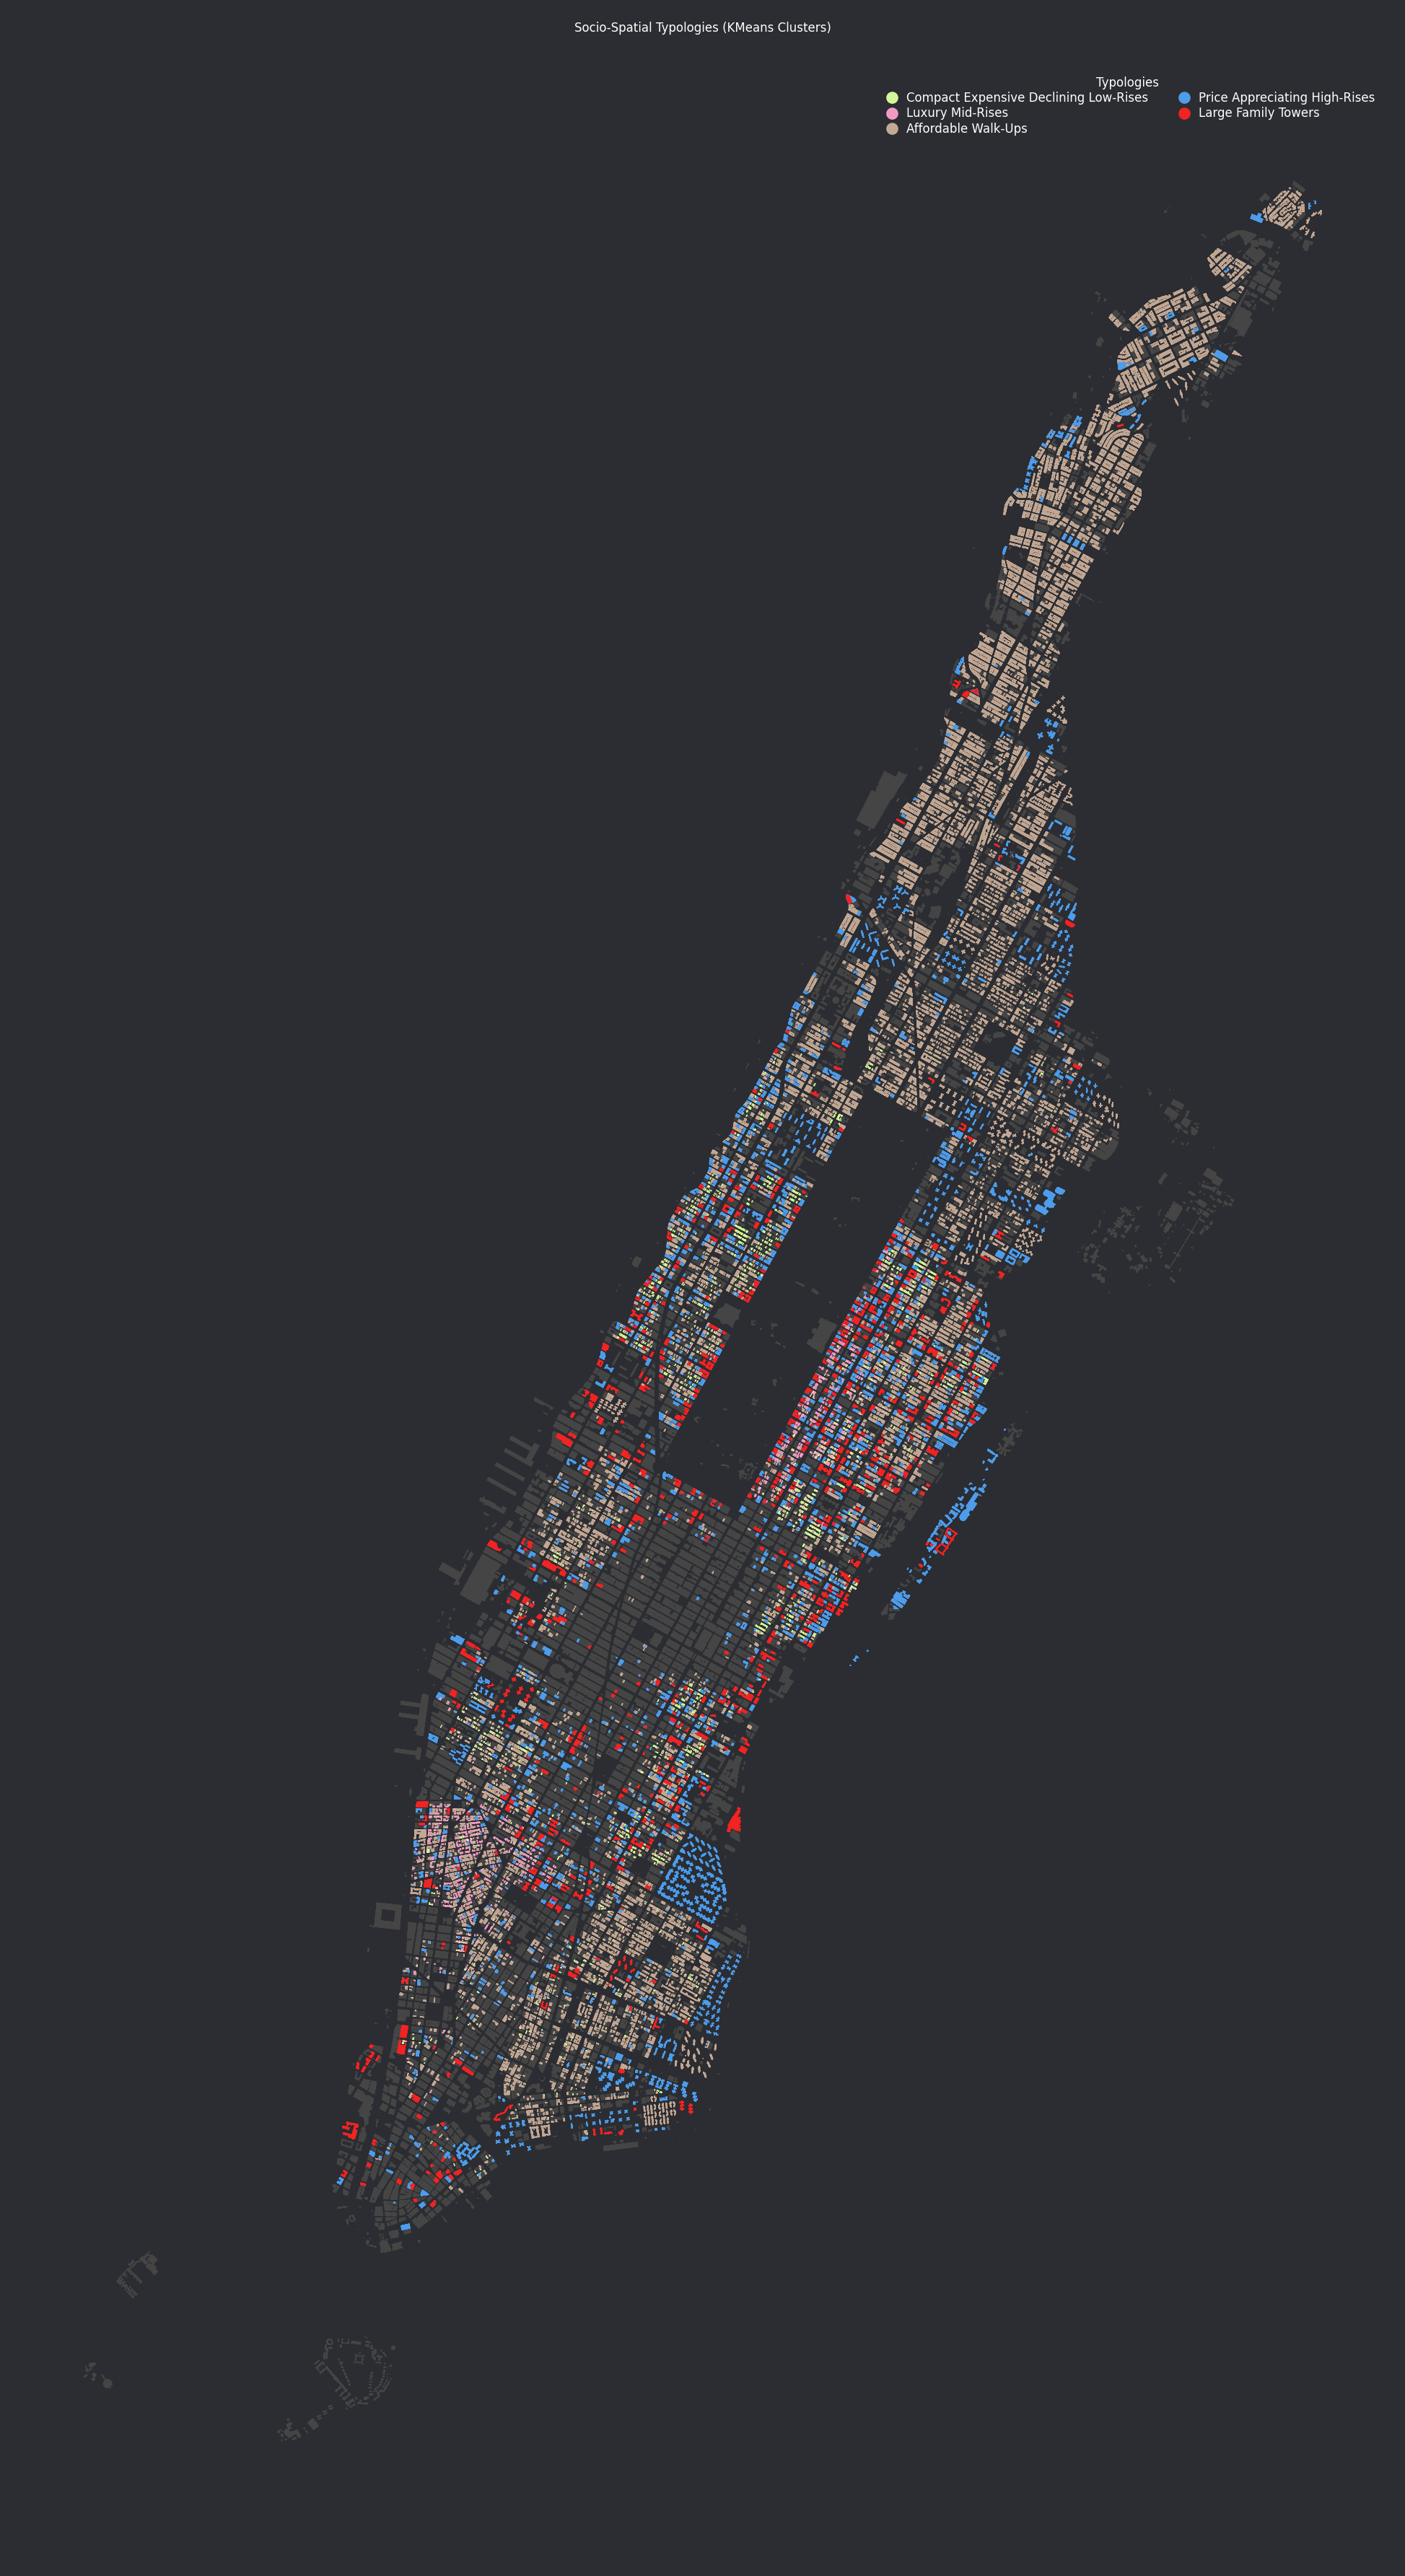

In [24]:
import matplotlib.pyplot as plt
from matplotlib.colors import ListedColormap
from pandas.api.types import CategoricalDtype

# --- base layers ---
nonres = manhattan[~manhattan['CURTAXCLASS'].isin([1, 2])]

# define the 6 cluster labels in order
cluster_labels = [
    'Compact Expensive Declining Low-Rises',
    'Luxury Mid-Rises',
    'Affordable Walk-Ups',
    'Price Appreciating High-Rises',
    'Large Family Towers'
]

# mapping dictionary (0–5 → name)
cluster_names = dict(enumerate(cluster_labels))

# assign cluster names into your residential dataframe
# assumes you already have a column "kmeans_label" in res_socio
res_socio["bldg_cat_socio_spatial"] = res_socio["kmeans_label"].map(cluster_names)

# custom colors for the 6 clusters
custom_colors = {
    'Compact Expensive Declining Low-Rises':     "#d3f898",
    'Luxury Mid-Rises':                          "#f19bc3",
    'Affordable Walk-Ups':                       "#c3a894",
    'Price Appreciating High-Rises':             "#4E9CEA",
    'Large Family Towers':                       "#f12323",
}

# enforce categorical order
cat_dtype = CategoricalDtype(categories=cluster_labels, ordered=True)
res_socio["bldg_cat_socio_spatial"] = res_socio["bldg_cat_socio_spatial"].astype(cat_dtype)

# colormap in the same order as cluster_labels
color_list = [custom_colors[c] for c in cluster_labels]
cmap = ListedColormap(color_list)

# ---- plot ----
fig, ax = plt.subplots(figsize=(10, 12), dpi=300, facecolor="#2B2D32")

# 1) BASE: non-residential in black
nonres.plot(ax=ax, color="#454545", linewidth=0, edgecolor="none")

# 2) RESIDENTIAL: 6 clusters
res_socio.plot(
    ax=ax,
    column="bldg_cat_socio_spatial",
    cmap=cmap,
    linewidth=0,
    edgecolor="none",
    legend=True,
    categorical=True,
    legend_kwds={
        "title": "Typologies",
        "fontsize": 4,
        "title_fontsize": 4,
        "ncol": 2,
        "markerscale": 0.4,
        "handletextpad": 0.2,
        "labelspacing": 0.2,
        "borderpad": 0.2,
        "frameon": False,
    },
)

ax.set_title("Socio-Spatial Typologies (KMeans Clusters)", color="white", fontsize=4, pad=12)
ax.set_axis_off()

leg = ax.get_legend()
if leg:
    for txt in leg.get_texts():
        txt.set_color("white")
    if leg.get_title() is not None:
        leg.get_title().set_color("white")

plt.tight_layout()
plt.show()
